# V-plot

- When proteins bind to DNA, they protect regions from nuclease cleavage
- Fragment lengths and positions relative to binding sites form a characteristic V-shaped pattern
- X-axis: Position relative to binding site
- Y-axis: Fragment length
- Z-axis (color): Count of fragments

### Why a V-Shape?

When a protein binds to DNA:

1. Directly at the binding site (X ≈ 0), we see mostly small fragments as the protein protects just that area

2. As we move away from the binding site (X moves away from 0), we start to see larger fragments because the nuclei can cut farther away

3. This creates a characteristic V-shape with the bottom of the V right at the protein binding site

### Analysis :

- Fragments with centers far from the binding site must be longer to overlap the binding site.
- Fragments with centers near the binding site can be shorter and still overlap.
- The minimum fragment length that can overlap the binding site creates the tip of the "V".

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from collections import defaultdict
import seaborn as sns

Processed 280653 unique (X,Y) pairs
X-range: -509 to 509
Y-range: 40 to 500


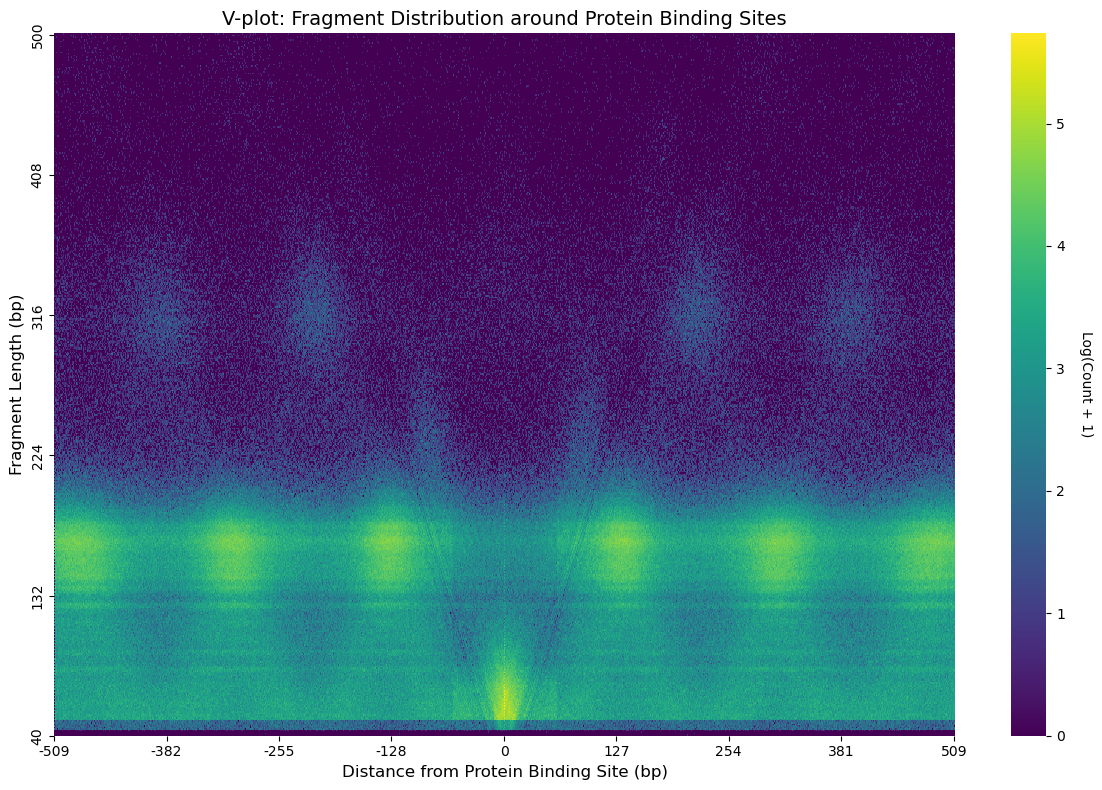

In [6]:
def v_plot(input, max_x=1000, max_y=500):
    xy_counts = defaultdict(int)

    with open(input, 'r') as inp:
        for line_num, line in enumerate(inp, 1):
            try:
                fields = line.strip().split('\t')

                prot_center = (int(fields[2]) + int(fields[3])) / 2
                frag_center = (int(fields[8]) + int(fields[9])) / 2

                x = int(frag_center - prot_center)
                y = int(fields[9]) - int(fields[8])

                if abs(x) <= max_x and y <= max_y:
                    xy_counts[(x, y)] += 1

            except (IndexError, ValueError) as e:
                print(f"Warning: Could not process line {line_num}: {e}")
                continue

    unique_x = sorted(set(i for i, _ in xy_counts.keys()))
    unique_y = sorted(set(i for _, i in xy_counts.keys()))

    print(f"Processed {len(xy_counts)} unique (X,Y) pairs")
    print(f"X-range: {min(unique_x)} to {max(unique_x)}")
    print(f"Y-range: {min(unique_y)} to {max(unique_y)}")

    count_matrix = np.zeros((len(unique_y), len(unique_x)))

    for i, a in enumerate(unique_y):
        for j, b in enumerate(unique_x):
            count_matrix[i, j] = xy_counts.get((b, a), 0)

    return unique_x, unique_y, count_matrix

try:
    input = "mapped.bed"
    x_values, y_values, count_matrix = v_plot(input)

    plt.figure(figsize=(12, 8))

    log_counts = np.log1p(count_matrix)

    ax = sns.heatmap(log_counts, cmap='viridis', xticklabels=500, yticklabels=50)

    x_ticks_pos = np.linspace(0, len(x_values)-1, 9).astype(int)
    x_ticks_labels = [x_values[i] for i in x_ticks_pos]
    plt.xticks(x_ticks_pos, x_ticks_labels)

    y_ticks_pos = np.linspace(0, len(y_values)-1, 6).astype(int)
    y_ticks_labels = [y_values[i] for i in y_ticks_pos]
    plt.yticks(y_ticks_pos, y_ticks_labels)

    plt.xlabel('Distance from Protein Binding Site (bp)', fontsize=12)
    plt.ylabel('Fragment Length (bp)', fontsize=12)
    plt.title('V-plot: Fragment Distribution around Protein Binding Sites', fontsize=14)

    plt.gca().invert_yaxis()

    cbar = ax.collections[0].colorbar
    cbar.set_label('Log(Count + 1)', rotation=270, labelpad=20)

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: Input file '{input}' not found")
except Exception as e:
    print(f"Error during V-plot generation: {str(e)}")